In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

In [3]:
from kp.scripts.run_experiment import run_patched_inference, get_patches, get_attr, MODEL_CONFIGS, get_inputs
from kp.utils.utils_io import dict_to_namespace
from kp.train.model_factory import model_factory
from kp.utils.constants import MODEL_TO_HFID

In [4]:
BASE_EXPERIMENTS_DIR = Path("/net/projects/clab/tnief/bidirectional-reversal/experiments/")

In [5]:
def find_results_files(base_dir: Path, allow_smoke_test: bool = False):
    """
    Recursively finds all 'results.json' files under the base_dir.
    """
    if not isinstance(base_dir, Path):
        base_dir = Path(base_dir)

    results_files = []
    print(f"Searching for 'results.json' files in: {base_dir}")
    
    for path in base_dir.rglob("results.json"):
        # Use `.parts` to check for subdirectories cleanly
        if any("archive" in part for part in path.parts):
            continue

        if allow_smoke_test:
            results_files.append(path)
        else:
            if not any("smoke_test" in part for part in path.parts):
                results_files.append(path)  
    
    print(f"Found {len(results_files)} 'results.json' files.")
    return results_files

In [6]:
from pathlib import Path
import os

def parse_path(results_file_path: Path, base_dir: Path):
    """
    Parses the file path to extract experiment metadata.
    Expected path structure relative to base_dir:
    dataset/model/patch_direction/patch_type/run_id/sentence_id/dropout_rate/results.json
    """
    # Ensure both are Path objects
    if not isinstance(results_file_path, Path):
        results_file_path = Path(results_file_path)
    if not isinstance(base_dir, Path):
        base_dir = Path(base_dir)

    try:
        # Ensure results file is within the base directory
        if base_dir not in results_file_path.parents:
            print(f"Warning: File {results_file_path} is not under base_dir {base_dir}")
            return None

        # Compute the relative path
        relative_path = results_file_path.relative_to(base_dir)
        components = list(relative_path.parts)
        
        if len(components) == 8 and components[-1] == "results.json":
            dataset, model, patch_direction, patch_type, run_id, sentence_id, dropout_rate, _ = components
            
            return {
                "dataset": dataset,
                "model": model,
                "patch_direction": patch_direction,
                "patch_type": patch_type,
                "run_id": run_id,
                "sentence_id": sentence_id,
                "dropout_rate": dropout_rate,
                "full_path": str(results_file_path)  # Store string path
            }
        else:
            print(f"Warning: Path structure mismatch for {results_file_path}. Relative: '{relative_path}', Components: {len(components)} {components}")
            return None
    except Exception as e:
        print(f"Error parsing path {results_file_path}: {e}")
        return None

In [7]:
def calculate_metrics_from_file(results_json_path, top_k=5):
    """
    Reads a results.json file and calculates metrics.
    Metrics: mean target rank, top-5 accuracy, mean target probability.
    Assumes target token rank is 1-indexed for top-5 accuracy (rank <= 5).
    """
    try:
        with open(results_json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading or parsing {results_json_path}: {e}")
        return None # Indicates a file read/parse error

    if "results" not in data or not isinstance(data["results"], list):
        # print(f"Warning: 'results' key missing or not a list in {results_json_path}")
        return { # Return NaNs if structure is invalid but file was readable
            "mean_target_rank": float('nan'),
            "top_5_accuracy": float('nan'),
            "mean_target_prob": float('nan')
        }
    
    if not data["results"]: # Empty list of results
        return {
            "mean_target_rank": float('nan'),
            "top_5_accuracy": float('nan'),
            "mean_target_prob": float('nan')
        }

    target_ranks = []
    is_in_top_k = []
    target_probs = []

    for res_item in data["results"]:
        if "target" in res_item and isinstance(res_item["target"], dict):
            target_info = res_item["target"]
            
            if "token_rank" in target_info and isinstance(target_info["token_rank"], (int, float)):
                rank = target_info["token_rank"] + 1 # Note: token_rank is 0-indexed
                target_ranks.append(rank)
                is_in_top_k.append(1 if rank <= top_k and rank >=1 else 0) # Ensure rank is positive
            else:
                target_ranks.append(float('nan'))
                is_in_top_k.append(float('nan'))

            if "token_prob" in target_info and isinstance(target_info["token_prob"], (int, float)):
                target_probs.append(target_info["token_prob"])
            else:
                target_probs.append(float('nan'))
        else: # Target info missing for a result item
            target_ranks.append(float('nan'))
            is_in_top_k.append(float('nan'))
            target_probs.append(float('nan'))
    
    mean_rank = np.nanmean(target_ranks) if any(not np.isnan(r) for r in target_ranks) else float('nan')
    top_k_acc = np.nanmean(is_in_top_k) if any(not np.isnan(r) for r in is_in_top_k) else float('nan')
    mean_prob = np.nanmean(target_probs) if any(not np.isnan(r) for r in target_probs) else float('nan')
    
    return {
        "mean_target_rank": mean_rank,
        "top_k_accuracy": top_k_acc,
        "mean_target_prob": mean_prob
    }

In [8]:
from collections import defaultdict

def organize_results(all_results_files, base_dir):
    """
    Organizes results into a nested dictionary:
    top_level[dataset][model][sentence][patch] = metrics_dict
    """
    organized_data = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    parsed_files_count = 0
    metrics_calculated_count = 0

    for file_path in all_results_files:
        parsed_info = parse_path(file_path, base_dir)
        if not parsed_info:
            # This file path didn't match the expected structure or couldn't be parsed.
            continue
        
        parsed_files_count += 1
        
        metrics = calculate_metrics_from_file(file_path)
        if metrics is None: 
            # Error reading or parsing the JSON content of this file.
            print(f"Skipping file due to content read/parse error: {file_path}")
            continue
        
        metrics_calculated_count += 1
            
        dataset = parsed_info["dataset"]
        model = parsed_info["model"]  # Changed to 'model'
        sentence_id = parsed_info["sentence_id"]
        patch_type = parsed_info["patch_type"]

        if patch_type == "no_patching":
            if "sft2pre" in file_path.parts:
                patch_type = "no_patching_sft2pre"
            elif "pre2sft" in file_path.parts:
                patch_type = "no_patching_pre2sft"

        organized_data[dataset][model][sentence_id][patch_type] = metrics
        
    print(f"Attempted to parse paths for {len(all_results_files)} files.")
    print(f"Successfully parsed path metadata for {parsed_files_count} files.")
    print(f"Successfully calculated metrics for {metrics_calculated_count} files.")
    print(f"Organized data into {len(organized_data)} datasets.")
    
    for dataset_name, models in organized_data.items():
        print(f"  Dataset '{dataset_name}' has {len(models)} model configurations.")
    
    return organized_data

In [9]:
allow_smoke_test = True
all_my_results_files = find_results_files(BASE_EXPERIMENTS_DIR, allow_smoke_test)

Searching for 'results.json' files in: /net/projects/clab/tnief/bidirectional-reversal/experiments
Found 26 'results.json' files.


In [10]:
all_my_results_files

[PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/pre2sft/no_patching/all_2025-05-08_12-10-29_checkpoint-26400_best_saved_checkpoint_2025-05-11_18-51-43_smoke_test/sentence_1/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/pre2sft/no_patching/all_2025-05-08_12-10-29_checkpoint-26400_best_saved_checkpoint_2025-05-11_18-51-43_smoke_test/sentence_2/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/pre2sft/no_patching/all_2025-05-08_12-10-29_checkpoint-26400_best_saved_checkpoint_2025-05-11_18-51-43_smoke_test/sentence_3/dropout_0.0_layer_count/results.json'),
 PosixPath('/net/projects/clab/tnief/bidirectional-reversal/experiments/fake_movies_real_actors/pythia-2.8b/sft2pre/no_patching/all_2025-05-08_12-10-29_checkpoint-26400_best_saved_c

In [11]:
organized_results = organize_results(all_my_results_files, BASE_EXPERIMENTS_DIR)

Attempted to parse paths for 26 files.
Successfully parsed path metadata for 26 files.
Successfully calculated metrics for 26 files.
Organized data into 1 datasets.
  Dataset 'fake_movies_real_actors' has 2 model configurations.


In [12]:
organized_results['fake_movies_real_actors']

defaultdict(<function __main__.organize_results.<locals>.<lambda>.<locals>.<lambda>()>,
            {'pythia-2.8b': defaultdict(dict,
                         {'sentence_1': {'no_patching_pre2sft': {'mean_target_rank': 1.0,
                            'top_k_accuracy': 1.0,
                            'mean_target_prob': 0.9994157592455546},
                           'no_patching_sft2pre': {'mean_target_rank': 405.3333333333333,
                            'top_k_accuracy': 0.0,
                            'mean_target_prob': 0.0019528003758750856},
                           'fe': {'mean_target_rank': 378.1333333333333,
                            'top_k_accuracy': 0.06666666666666667,
                            'mean_target_prob': 0.0019858184864763946},
                           'lt': {'mean_target_rank': 92.06666666666666,
                            'top_k_accuracy': 0.23333333333333334,
                            'mean_target_prob': 0.024645453192836914}},
                   

In [13]:
def plot_metric(organized_data, metric_key):
    """
    Generates bar plots for a specified metric across patch configurations,
    grouped by dataset, model, and sentence.

    Args:
        organized_data (dict): The nested dictionary structured as:
            organized_data[dataset][model][sentence][patch] = metrics_dict
            where metrics_dict contains the specified metric.
        metric_key (str): The key of the metric to plot (e.g., 'top_k_accuracy', 'mean_target_prob', 'mean_target_rank').
    """

    if not organized_data:
        print("No data available to plot.")
        return

    # Define the label and color for different metrics
    metric_config = {
        "top_k_accuracy": {"label": "Top-K Accuracy", "color": "viridis"},
        "mean_target_prob": {"label": "Mean Target Probability", "color": "plasma"},
        "mean_target_rank": {"label": "Mean Target Rank", "color": "cividis"},
    }

    if metric_key not in metric_config:
        raise ValueError(f"Metric '{metric_key}' is not valid. Choose from {list(metric_config.keys())}.")

    config = metric_config[metric_key]

    # Iterate over the datasets, models, and sentences
    for dataset_name, models_data in organized_data.items():
        for model_name, sentences_data in models_data.items():
            for sentence_id, patch_config_results in sentences_data.items():
                
                if not patch_config_results:
                    print(f"Skipping plots for {dataset_name} / {model_name} / {sentence_id}: No patch data found.")
                    continue
                
                patch_names = []
                metric_values = []

                # Sort patch names for consistent ordering
                for patch_name, metrics_dict in sorted(patch_config_results.items()):
                    if metric_key in metrics_dict and not np.isnan(metrics_dict[metric_key]):
                        patch_names.append(patch_name)
                        metric_values.append(metrics_dict[metric_key])

                if not patch_names:
                    print(f"No valid data for {metric_key} in {dataset_name} / {model_name} / {sentence_id}")
                    continue

                # Plot
                plt.figure(figsize=(max(10, len(patch_names) * 0.8), 7))
                colors = plt.cm.get_cmap(config["color"])(np.linspace(0, 1, len(patch_names)))
                bars = plt.bar(patch_names, metric_values, color=colors)

                # Titles and labels
                plt.title(f"{config['label']}\nDataset: {dataset_name} | Model: {model_name} | Sentence: {sentence_id}", fontsize=14)
                plt.xlabel("Patch Configuration", fontsize=12)
                plt.ylabel(config["label"], fontsize=12)
                
                plt.xticks(rotation=45, ha="right")
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                # Annotate bars with values
                for bar in bars:
                    yval = bar.get_height()
                    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f"{yval:.3f}", ha='center', va='bottom', fontsize=8)

                plt.tight_layout()
                plt.show()

/tmp/ipykernel_1162862/1350090825.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(config["color"])(np.linspace(0, 1, len(patch_names)))


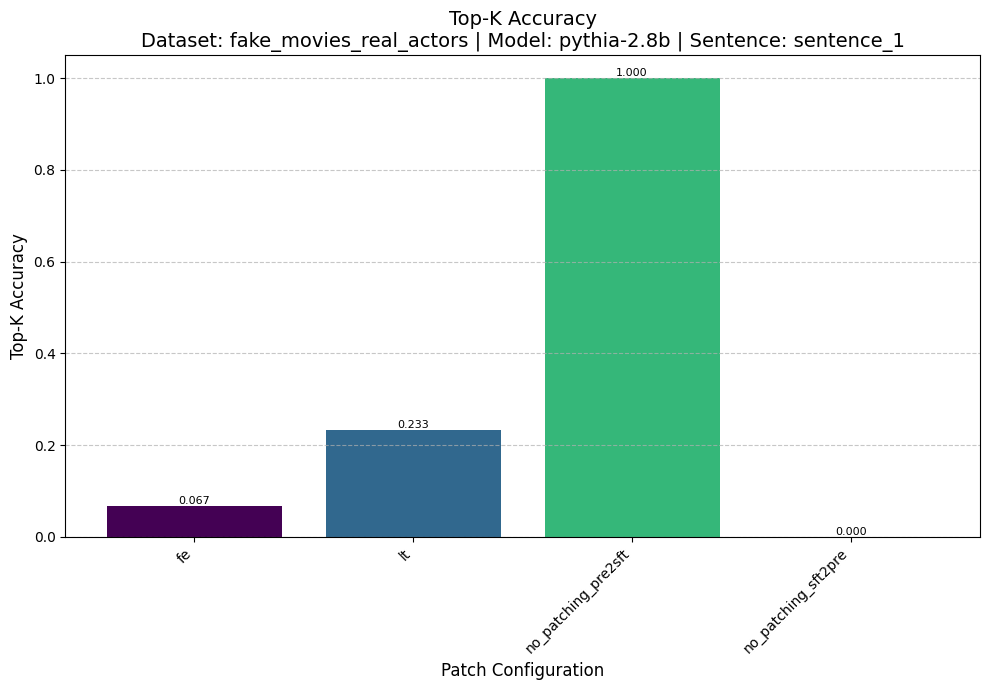

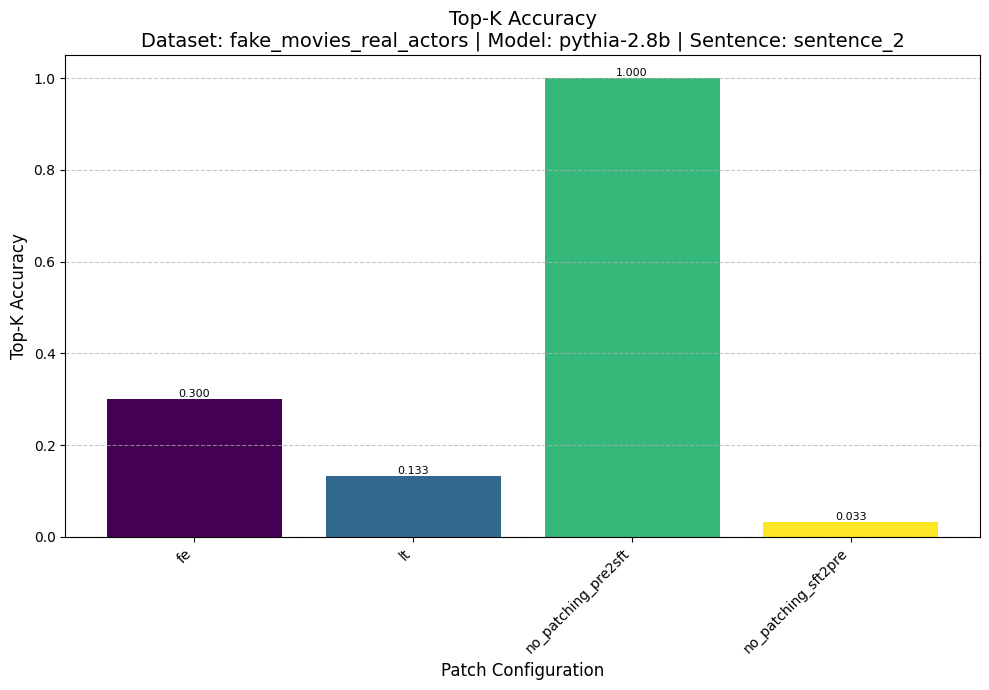

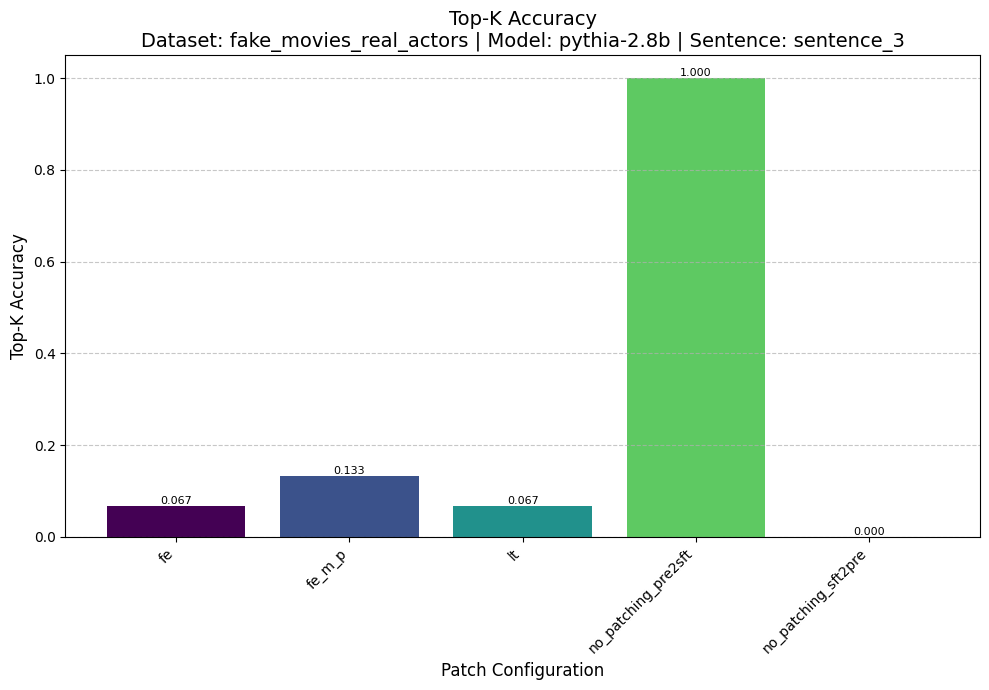

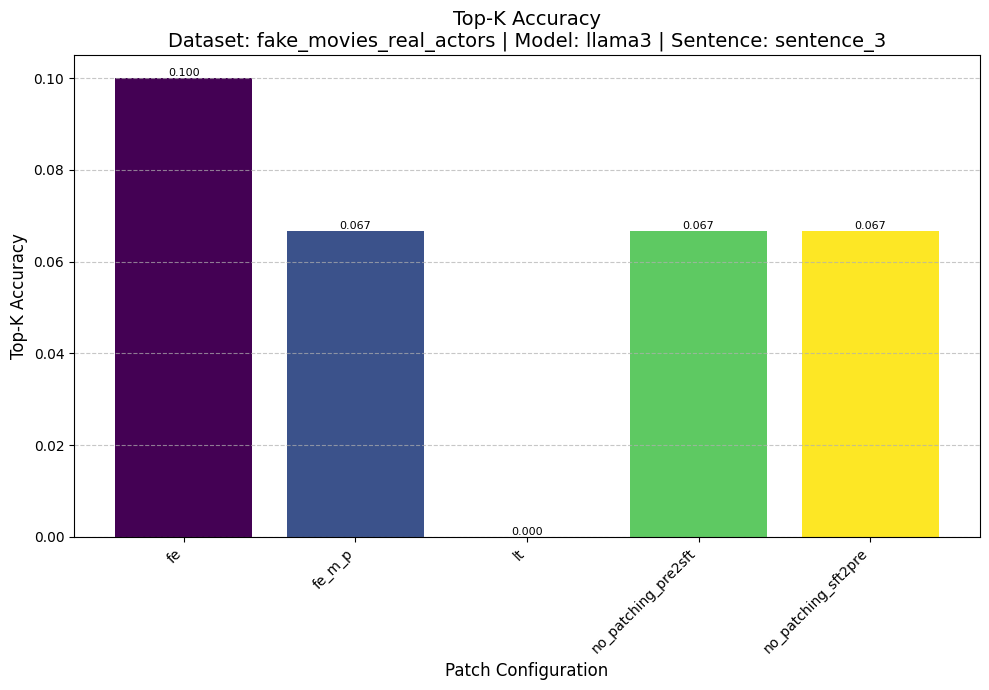

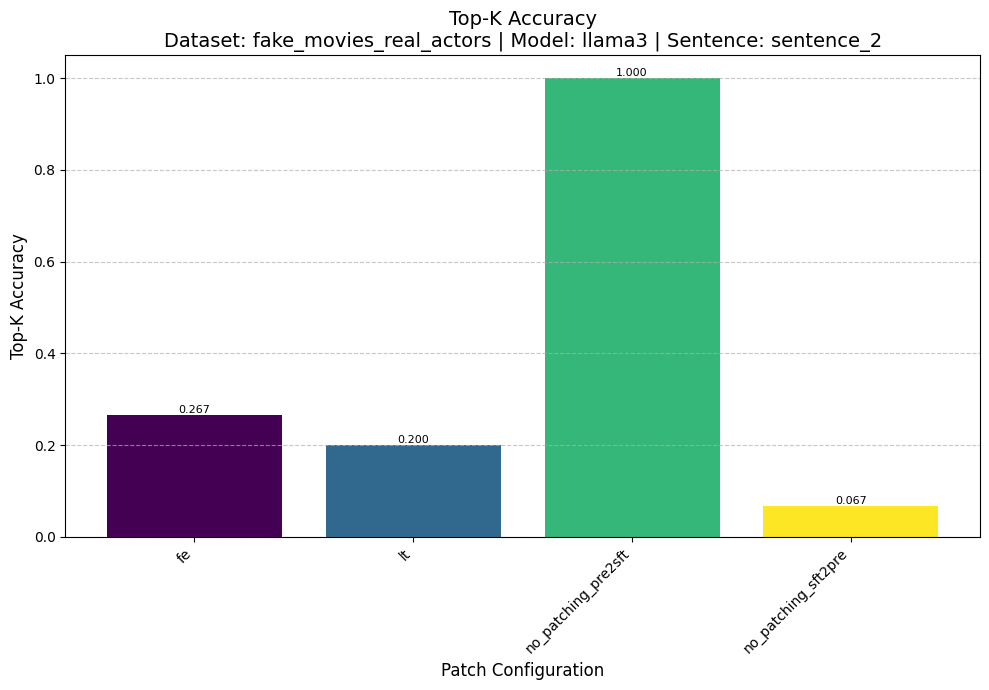

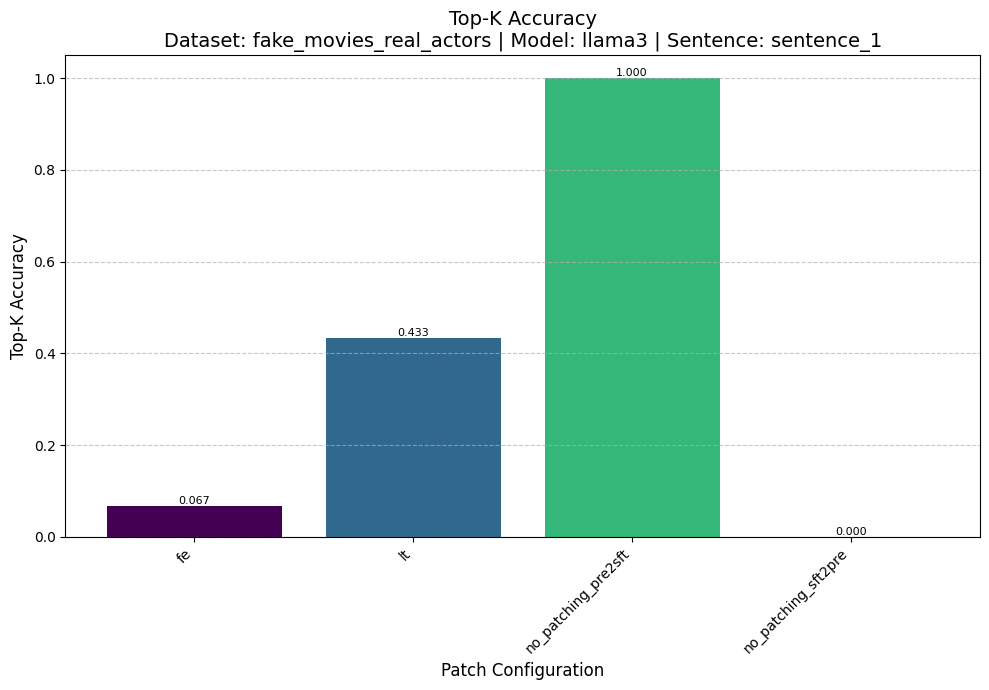

In [14]:
metric_key = "top_k_accuracy"
plot_metric(organized_results, metric_key)

/tmp/ipykernel_1162862/1350090825.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(config["color"])(np.linspace(0, 1, len(patch_names)))


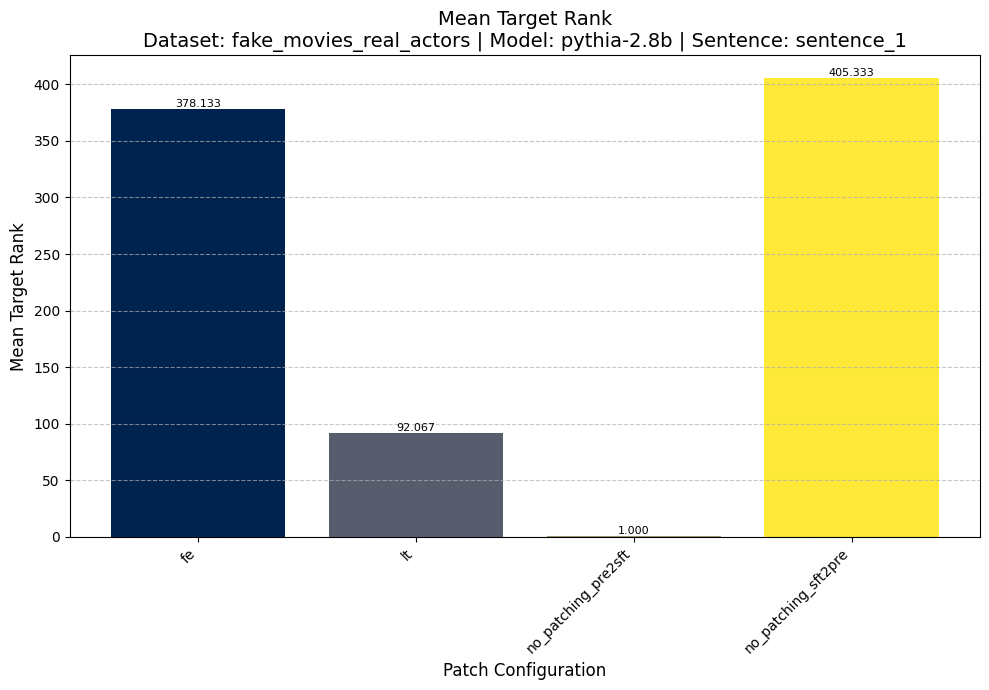

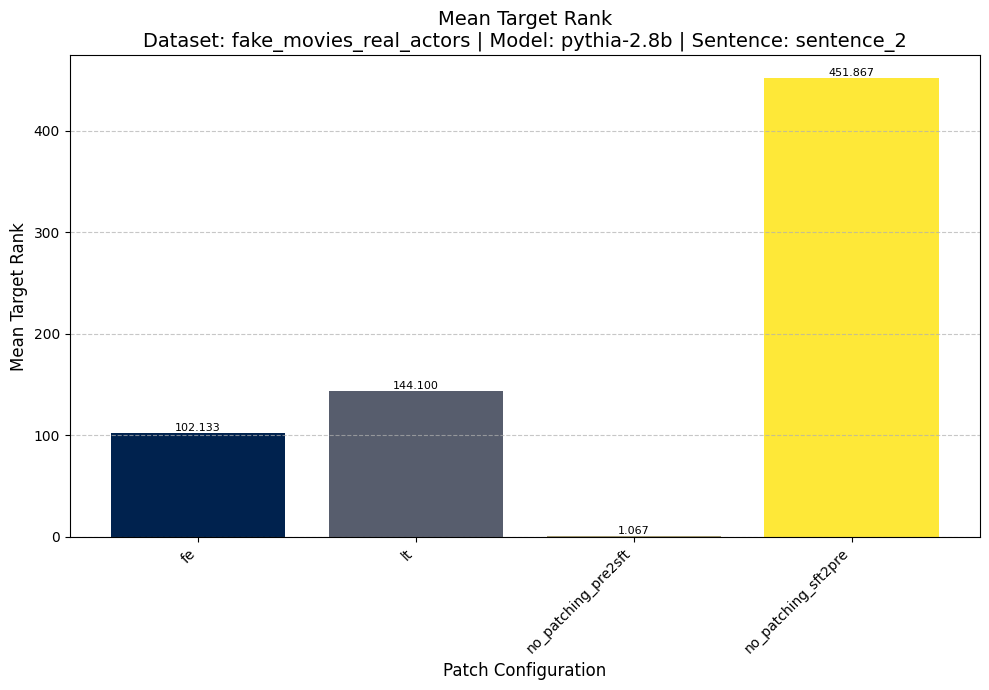

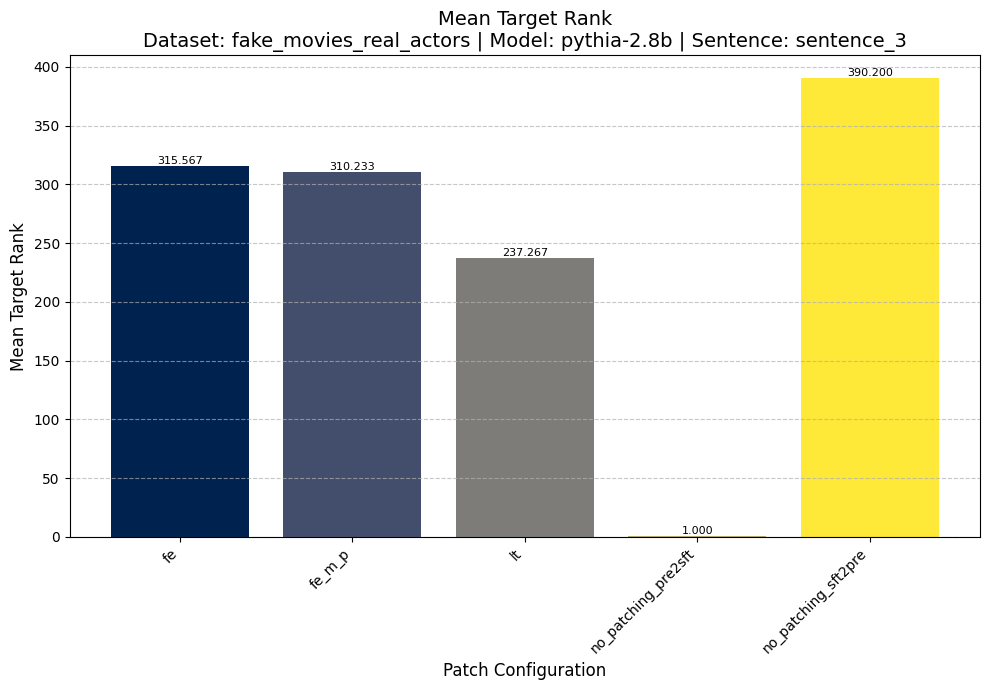

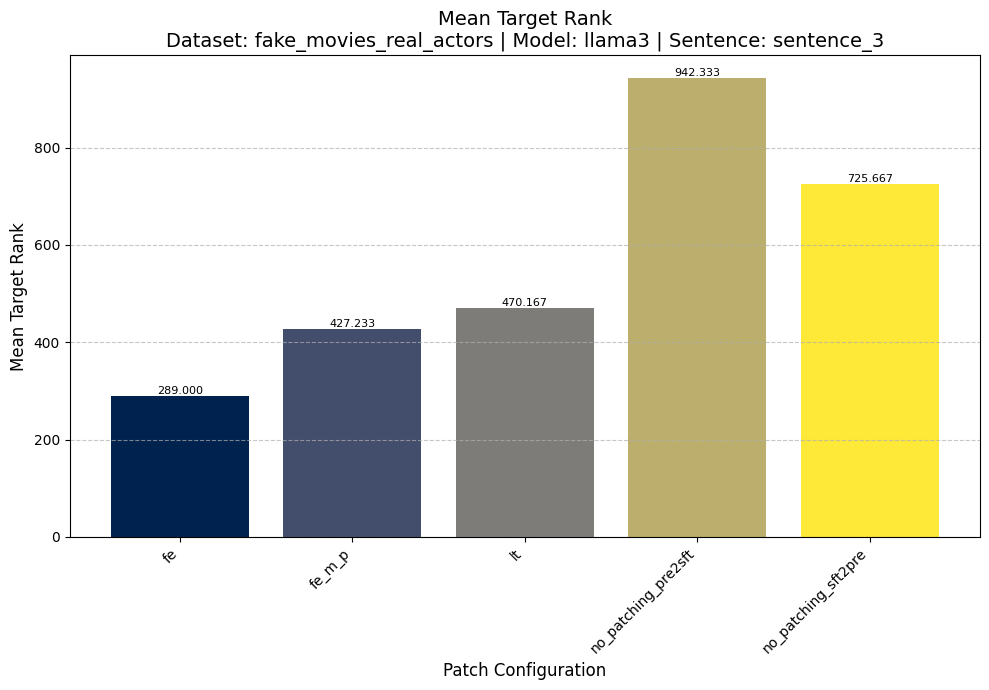

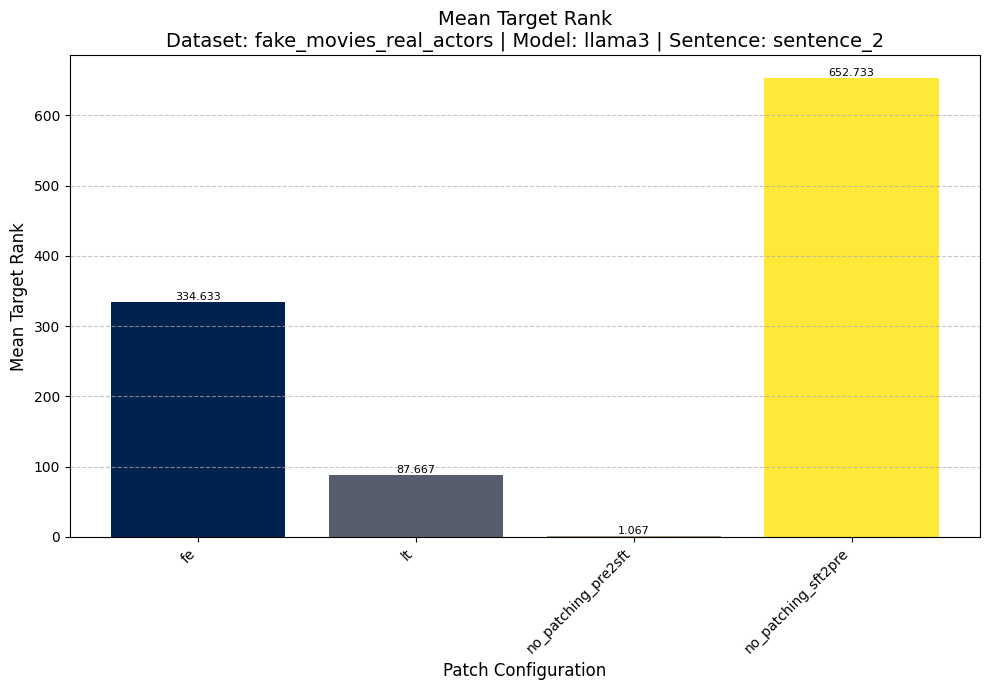

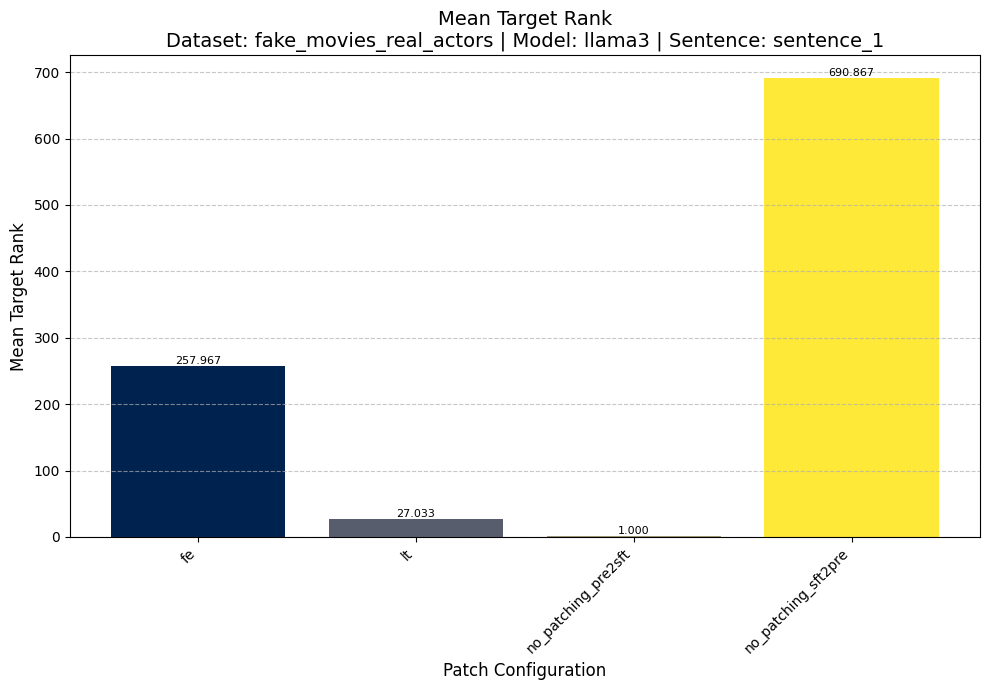

In [15]:
metric_key = "mean_target_rank"
plot_metric(organized_results, metric_key)

/tmp/ipykernel_1162862/1350090825.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(config["color"])(np.linspace(0, 1, len(patch_names)))


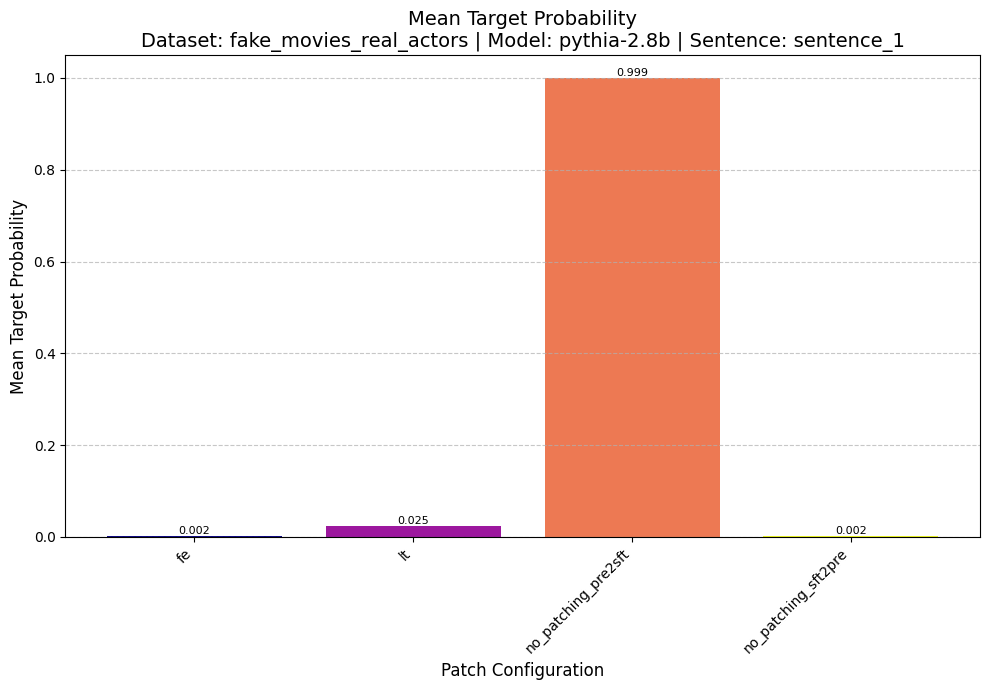

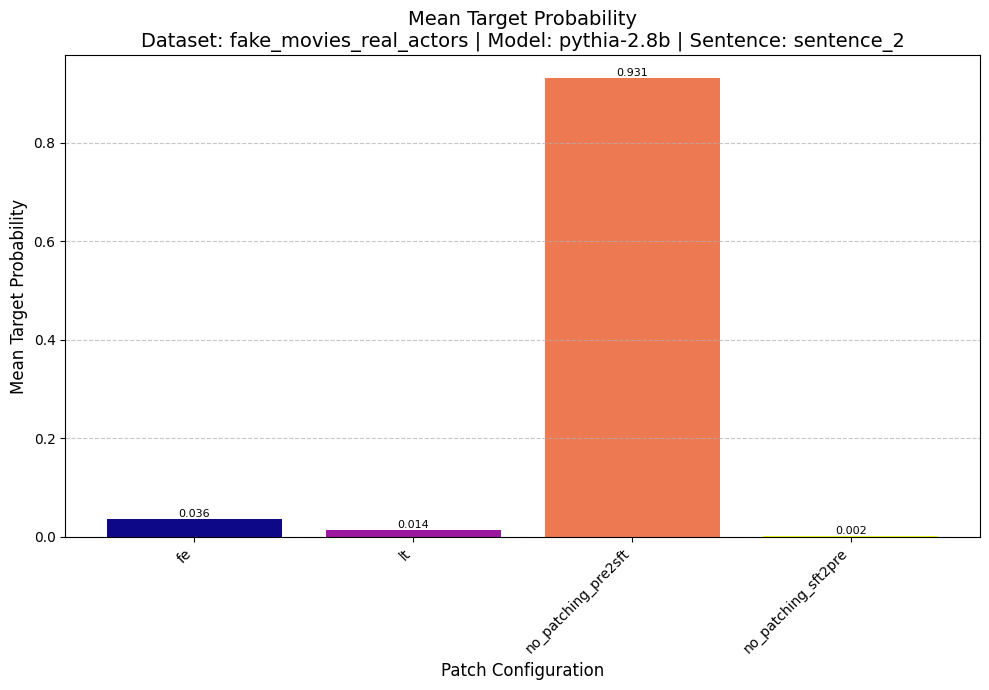

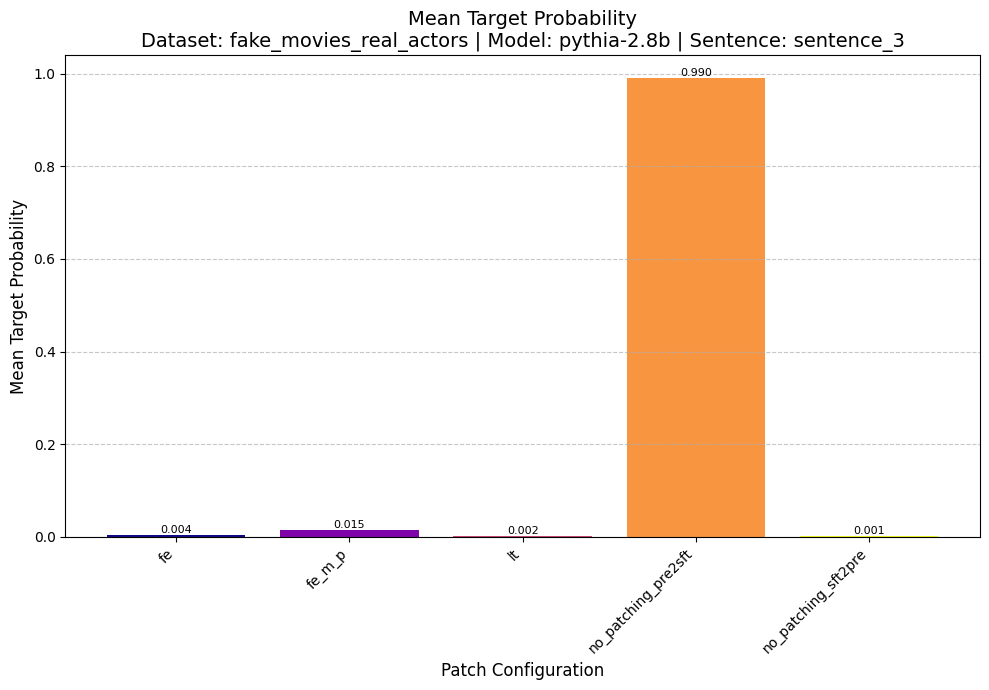

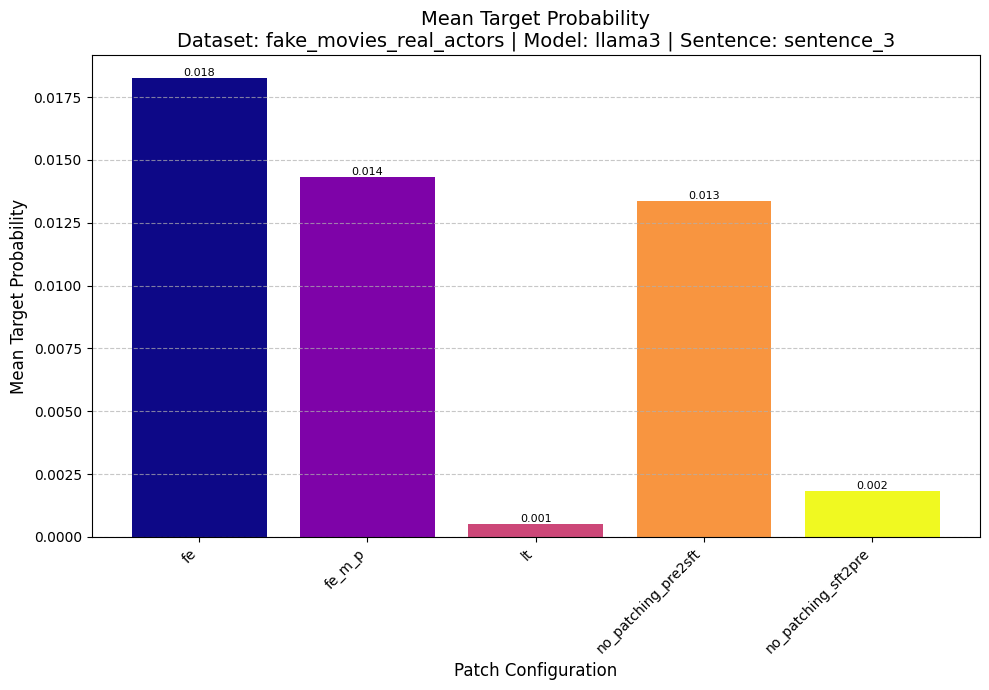

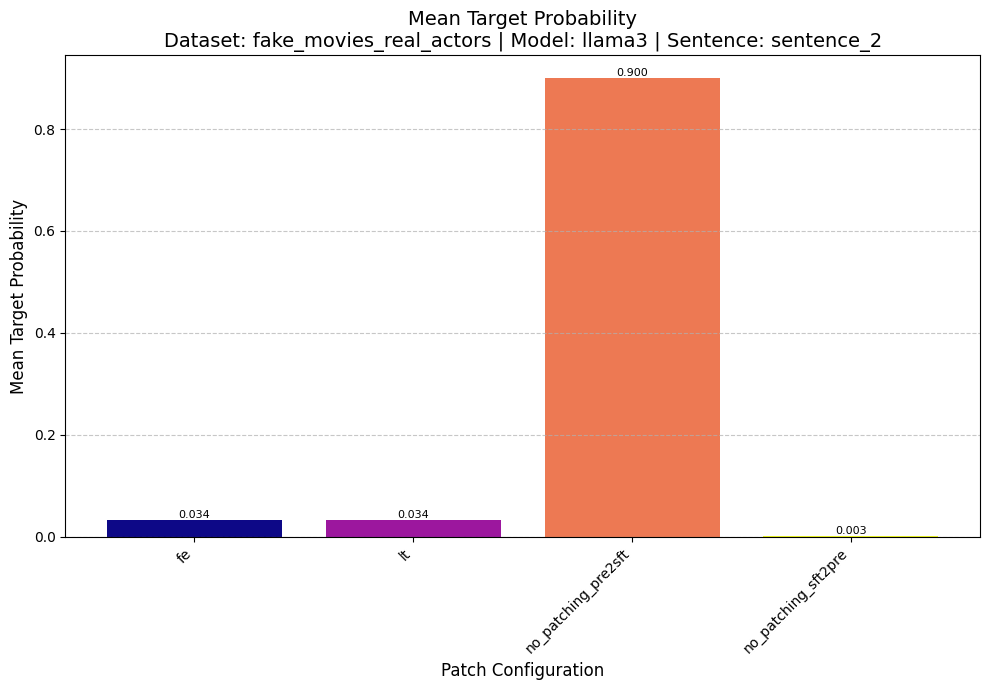

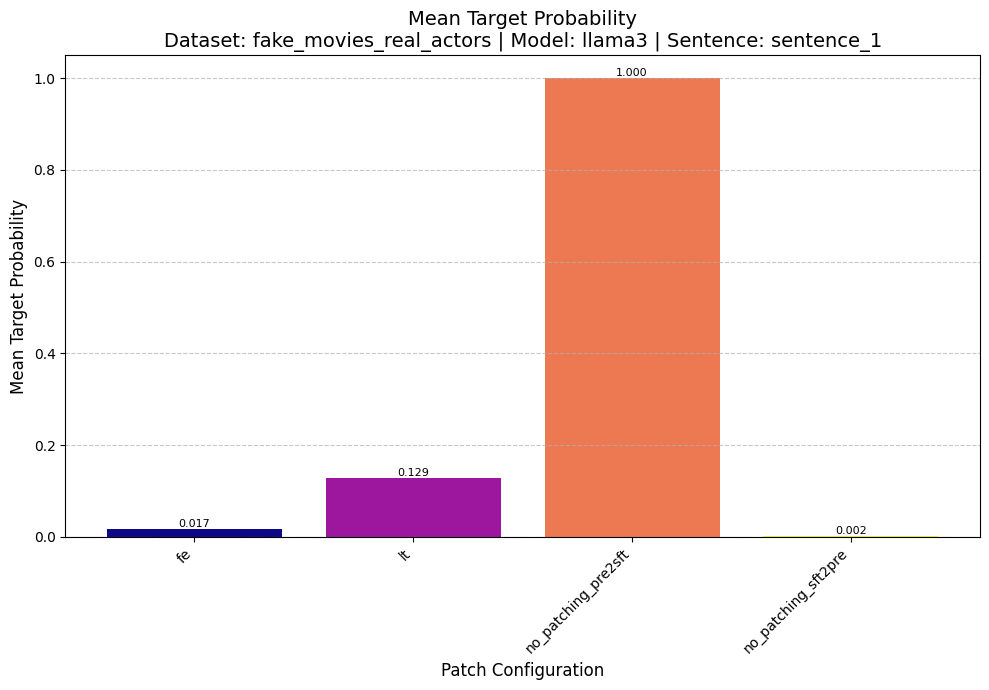

In [16]:
metric_key = "mean_target_prob"
plot_metric(organized_results, metric_key)